In [1]:
import sys
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [2]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 09:21:31] [setup] RAM Tracking...
[codecarbon INFO @ 09:21:31] [setup] GPU Tracking...
[codecarbon INFO @ 09:21:31] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:21:31] [setup] CPU Tracking...
[codecarbon WARNING @ 09:21:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:21:34] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 09:21:34] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 09:21:34] >>> Tracker's metadata:
[codecarbon INFO @ 09:21:34]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 09:21:34]   Python version: 3.11.3
[codecarbon INFO @ 09:21:34]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 09:21:34]   Available RAM : 256.000 GB
[codecarbon INFO @ 09:21:34]   CPU count: 24
[codecarbon INFO @ 09:21:34]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [3]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


de94dni3oddp


In [8]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
import pandas as pd
path_to_files = "/fp/projects01/ec307/ec-krimhau/github_datasets/HP_vs_med_low"
file_name = "high_vs_med_low_top_50_hp_repos_balanced_github.csv"
full_training_df = pd.read_csv(f"{path_to_files}/{file_name}")
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [12]:
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [13]:
import pandas as pd
fine_tuning_df = pd.read_csv("clean_high_vs_med_low_rust_testset.csv")
fine_tuning_df

,text,label
0,rustdoc regression in display of macrorules ma...,1
1,clarify which tcpstream methods wont work in n...,0
2,spurious error about sized bound when trait ne...,0
3,rust enums with discriminators greater than ar...,0
4,investigate implementing an localization libra...,1
...,...,...
1565,recent nightly versions break thumb targets he...,1
1566,when encountering for trait object do not also...,0
1567,rustc does display a correct error message on ...,1
1568,rustdoc dos line endings cause extra newlines ...,1


In [14]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [15]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [16]:
fine_tune_train_df

,text,label
1492,unclear if from for is network order or not th...,0
985,size no longer known at compiletime possibly r...,1
432,is allowed on with targetfeature this works bu...,0
964,clone derive documentation is inconsistent the...,0
1170,significant performance regression on the enco...,1
...,...,...
838,rustcmirfindoutlivesblamespan called optionunw...,0
1075,the attribute can be applied to nonfunctions i...,0
483,tracking issue for linkargs stabilization this...,0
435,array as asm output ices llvm rsfn main let ar...,0


In [17]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [18]:
df

,label,text
0,0,use correct case for help documentation in eg ...
1,0,overwriting bookmark folders when syncing devi...
2,0,no results if country is specified in the quer...
3,0,prepopulate subject of message when clicking r...
4,0,timeout on wiki listoffeaturedimages does not ...
...,...,...
36701,0,rustcmirfindoutlivesblamespan called optionunw...
36702,0,the attribute can be applied to nonfunctions i...
36703,0,tracking issue for linkargs stabilization this...
36704,0,array as asm output ices llvm rsfn main let ar...


In [19]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [20]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        6156
       0        6080
1      0        6166
       1        6069
2      0        6127
       1        6108
Name: count, dtype: int64

In [21]:
df

,label,text,kfold
0,0,use correct case for help documentation in eg ...,1
1,0,overwriting bookmark folders when syncing devi...,1
2,0,no results if country is specified in the quer...,0
3,0,prepopulate subject of message when clicking r...,2
4,0,timeout on wiki listoffeaturedimages does not ...,2
...,...,...,...
36701,0,rustcmirfindoutlivesblamespan called optionunw...,1
36702,0,the attribute can be applied to nonfunctions i...,0
36703,0,tracking issue for linkargs stabilization this...,2
36704,0,array as asm output ices llvm rsfn main let ar...,2


In [22]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [23]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [24]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [25]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [26]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [27]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [29]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [30]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [31]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [32]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [33]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 765/765 [02:04<00:00,  6.16it/s, Epoch=1, LR=9.7e-6, Valid_Loss=0.495]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7167    0.8377    0.7725      6080
          HP     0.8076    0.6730    0.7342      6156

    accuracy                         0.7548     12236
   macro avg     0.7622    0.7553    0.7533     12236
weighted avg     0.7624    0.7548    0.7532     12236

Accuracy = 0.7548
F1_score = 0.7342
Validation Loss Improved (inf ---> 0.4953449080878124)
Model Saved



100%|██████████| 765/765 [02:04<00:00,  6.16it/s, Epoch=2, LR=8.86e-6, Valid_Loss=0.504]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7275    0.8556    0.7863      6080
          HP     0.8273    0.6834    0.7485      6156

    accuracy                         0.7690     12236
   macro avg     0.7774    0.7695    0.7674     12236
weighted avg     0.7777    0.7690    0.7673     12236

Accuracy = 0.769
F1_score = 0.7485



100%|██████████| 765/765 [02:04<00:00,  6.16it/s, Epoch=3, LR=7.57e-6, Valid_Loss=0.492]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7219    0.8799    0.7931      6080
          HP     0.8487    0.6652    0.7458      6156

    accuracy                         0.7719     12236
   macro avg     0.7853    0.7726    0.7695     12236
weighted avg     0.7857    0.7719    0.7693     12236

Accuracy = 0.7719
F1_score = 0.7458
Validation Loss Improved (0.4953449080878124 ---> 0.49185514893357213)
Model Saved

Training complete in 1h 1m 57s
Best Loss: 0.4919


Train Loss,█▃▁
Valid Accuracy,▁▇█
Valid F1_score,▁█▇
Valid Loss,▃█▁
Best Loss,0.49186
Train Loss,0.40729
Valid Accuracy,0.7719
Valid F1_score,0.7458
Valid Loss,0.49186



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 765/765 [02:05<00:00,  6.12it/s, Epoch=1, LR=9.7e-6, Valid_Loss=0.5]  


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7391    0.7879    0.7627      6166
          HP     0.7690    0.7174    0.7423      6069

    accuracy                         0.7529     12235
   macro avg     0.7540    0.7526    0.7525     12235
weighted avg     0.7539    0.7529    0.7526     12235

Accuracy = 0.7529
F1_score = 0.7423
Validation Loss Improved (inf ---> 0.5002456478747145)
Model Saved



100%|██████████| 765/765 [02:05<00:00,  6.11it/s, Epoch=2, LR=8.86e-6, Valid_Loss=0.474]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7643    0.7882    0.7760      6166
          HP     0.7777    0.7530    0.7652      6069

    accuracy                         0.7707     12235
   macro avg     0.7710    0.7706    0.7706     12235
weighted avg     0.7710    0.7707    0.7707     12235

Accuracy = 0.7707
F1_score = 0.7652
Validation Loss Improved (0.5002456478747145 ---> 0.47399304672119613)
Model Saved



100%|██████████| 765/765 [02:05<00:00,  6.11it/s, Epoch=3, LR=7.57e-6, Valid_Loss=0.473]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7447    0.8519    0.7947      6166
          HP     0.8238    0.7032    0.7588      6069

    accuracy                         0.7782     12235
   macro avg     0.7842    0.7776    0.7767     12235
weighted avg     0.7839    0.7782    0.7769     12235

Accuracy = 0.7782
F1_score = 0.7588
Validation Loss Improved (0.47399304672119613 ---> 0.4729075257857088)
Model Saved

Training complete in 0h 48m 15s
Best Loss: 0.4729


Train Loss,█▃▁
Valid Accuracy,▁▆█
Valid F1_score,▁█▆
Valid Loss,█▁▁
Best Loss,0.47291
Train Loss,0.41074
Valid Accuracy,0.7782
Valid F1_score,0.7588
Valid Loss,0.47291



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 765/765 [02:05<00:00,  6.10it/s, Epoch=1, LR=9.7e-6, Valid_Loss=0.517]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7585    0.7067    0.7317      6127
          HP     0.7246    0.7742    0.7486      6108

    accuracy                         0.7404     12235
   macro avg     0.7415    0.7405    0.7401     12235
weighted avg     0.7416    0.7404    0.7401     12235

Accuracy = 0.7404
F1_score = 0.7486
Validation Loss Improved (inf ---> 0.5170953738577375)
Model Saved



100%|██████████| 765/765 [02:05<00:00,  6.10it/s, Epoch=2, LR=8.86e-6, Valid_Loss=0.464]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7622    0.8108    0.7858      6127
          HP     0.7973    0.7462    0.7709      6108

    accuracy                         0.7786     12235
   macro avg     0.7797    0.7785    0.7783     12235
weighted avg     0.7797    0.7786    0.7783     12235

Accuracy = 0.7786
F1_score = 0.7709
Validation Loss Improved (0.5170953738577375 ---> 0.46433541002105977)
Model Saved



100%|██████████| 765/765 [02:05<00:00,  6.09it/s, Epoch=3, LR=7.57e-6, Valid_Loss=0.479]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7678    0.8102    0.7884      6127
          HP     0.7984    0.7543    0.7757      6108

    accuracy                         0.7823     12235
   macro avg     0.7831    0.7822    0.7821     12235
weighted avg     0.7831    0.7823    0.7821     12235

Accuracy = 0.7823
F1_score = 0.7757

Training complete in 0h 48m 17s
Best Loss: 0.4643


Train Loss,█▃▁
Valid Accuracy,▁▇█
Valid F1_score,▁▇█
Valid Loss,█▁▃
Best Loss,0.46434
Train Loss,0.41325
Valid Accuracy,0.7823
Valid F1_score,0.7757
Valid Loss,0.47935


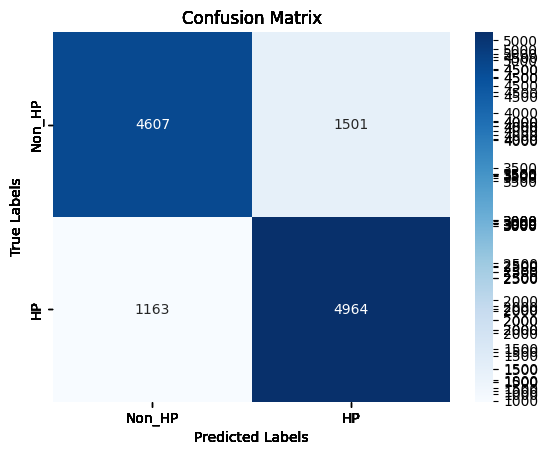

In [34]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [35]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [36]:
test_df = fine_tune_test_df

In [37]:
test_df

,text,label
1346,trustedrandomaccess optimization for zip conta...,1
308,addressing a share static mut should be safe w...,0
881,ice on pattern match against const static i ma...,1
430,confusing error message associated with univer...,1
968,backslash at the end of line followed by n on ...,0
...,...,...
1130,incremental compilation bug with async fn meth...,1
1294,rustc panicked at failed to lookup sourcefile ...,1
860,rustc crashes with exit code channels beta and...,1
1459,inline assembly with tied operands of differen...,0


In [38]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [39]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [40]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [41]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [42]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [43]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


Fold 1


100%|██████████| 69/69 [00:12<00:00,  5.57it/s]


Fold 2


100%|██████████| 69/69 [00:12<00:00,  5.56it/s]


In [44]:
deberta_predictions


[array([[0.5362542 , 0.4637458 ],
        [0.81722015, 0.18277982],
        [0.5077354 , 0.4922646 ],
        ...,
        [0.04965728, 0.9503428 ],
        [0.8141374 , 0.18586256],
        [0.3389045 , 0.6610955 ]], dtype=float32),
 array([[0.5518968 , 0.4481032 ],
        [0.5934837 , 0.40651634],
        [0.36807606, 0.6319239 ],
        ...,
        [0.12465677, 0.87534326],
        [0.80859303, 0.19140694],
        [0.5474704 , 0.4525296 ]], dtype=float32),
 array([[0.3894255 , 0.6105745 ],
        [0.69895655, 0.30104345],
        [0.5236888 , 0.47631127],
        ...,
        [0.22031604, 0.77968395],
        [0.72429013, 0.27570993],
        [0.48432776, 0.5156722 ]], dtype=float32)]

In [45]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.4925255 , 0.5074745 ],
       [0.7032201 , 0.29677987],
       [0.46650007, 0.53349996],
       ...,
       [0.13154335, 0.86845666],
       [0.7823402 , 0.21765982],
       [0.45690086, 0.5430991 ]], dtype=float32)

In [46]:
len(predictions)

1099

In [47]:
predictions

array([[0.4925255 , 0.5074745 ],
       [0.7032201 , 0.29677987],
       [0.46650007, 0.53349996],
       ...,
       [0.13154335, 0.86845666],
       [0.7823402 , 0.21765982],
       [0.45690086, 0.5430991 ]], dtype=float32)

In [48]:
test_df["prediction_0"] = predictions[:, 0] 

In [49]:
test_df["prediction_1"] = predictions[:, 1] 

In [50]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [51]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
1346,trustedrandomaccess optimization for zip conta...,1,0.492525,0.507474,0,0,1
308,addressing a share static mut should be safe w...,0,0.703220,0.296780,0,0,0
881,ice on pattern match against const static i ma...,1,0.466500,0.533500,0,1,0
430,confusing error message associated with univer...,1,0.772085,0.227915,0,0,0
968,backslash at the end of line followed by n on ...,0,0.663556,0.336444,0,0,0
...,...,...,...,...,...,...,...
1130,incremental compilation bug with async fn meth...,1,0.083691,0.916309,1,1,1
1294,rustc panicked at failed to lookup sourcefile ...,1,0.469691,0.530309,1,0,1
860,rustc crashes with exit code channels beta and...,1,0.131543,0.868457,1,1,1
1459,inline assembly with tied operands of differen...,0,0.782340,0.217660,0,0,0


In [52]:
len(test_df)

1099

In [53]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [54]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [55]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [56]:
test_df["pred"] = test_df["pred"].astype(int)

In [57]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
1346,trustedrandomaccess optimization for zip conta...,1,0.492525,0.507474,0,0,1,prediction_1,1
308,addressing a share static mut should be safe w...,0,0.703220,0.296780,0,0,0,prediction_0,0
881,ice on pattern match against const static i ma...,1,0.466500,0.533500,0,1,0,prediction_1,1
430,confusing error message associated with univer...,1,0.772085,0.227915,0,0,0,prediction_0,0
968,backslash at the end of line followed by n on ...,0,0.663556,0.336444,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1130,incremental compilation bug with async fn meth...,1,0.083691,0.916309,1,1,1,prediction_1,1
1294,rustc panicked at failed to lookup sourcefile ...,1,0.469691,0.530309,1,0,1,prediction_1,1
860,rustc crashes with exit code channels beta and...,1,0.131543,0.868457,1,1,1,prediction_1,1
1459,inline assembly with tied operands of differen...,0,0.782340,0.217660,0,0,0,prediction_0,0


In [58]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[378 162]
 [219 340]]


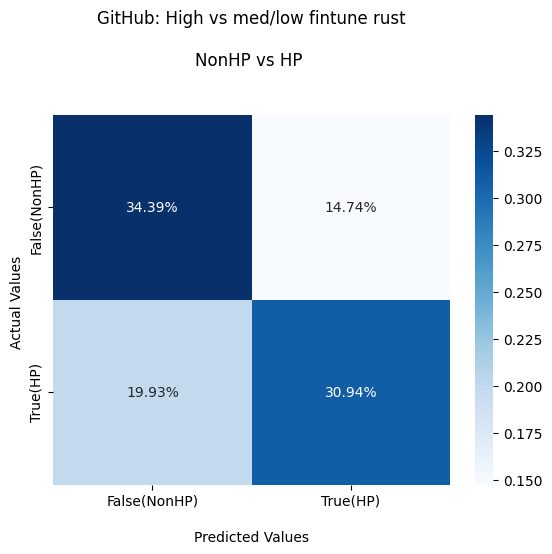

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('GitHub: High vs med/low fintune rust\n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [60]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       540
           1       0.68      0.61      0.64       559

    accuracy                           0.65      1099
   macro avg       0.66      0.65      0.65      1099
weighted avg       0.66      0.65      0.65      1099



In [61]:
test_df[["text","label","pred"]].to_csv("rust_70_Test_inference.csv")

In [62]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.30934081776162403


In [63]:
tracker.stop()

0.025511553430227308